# VAE for anomaly detection in text

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
E: Could not get lock /var/lib/apt/lists/lock - open (11: Resource temporarily unavailable)
E: Unable to lock directory /var/lib/apt/lists/
E: Could not get lock /var/lib/dpkg/lock-frontend - open (11: Resource temporarily unavailable)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), is another process using it?
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=o

In [0]:
import pickle
import itertools
import numpy as np
from scipy import spatial
from scipy.stats import norm
import nltk.data
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import reuters
from nltk. corpus import gutenberg
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize
from gensim.models import KeyedVectors
from keras.layers import Input, Dense, Lambda, Layer
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.models import load_model
from keras import backend as K
from keras import metrics
import matplotlib.pyplot as plt
import sklearn.metrics as skl
import seaborn as sns

nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Text Data

In [0]:
with open ('drive/Seminar/data/reviews_processed.pickle', 'rb') as f:
    data = pickle.load(f)
print("Total reviews: ", len(data))

data_min = np.array(data).min()
data_max = np.array(data).max()
with open ('drive/Seminar/data/scale_values.pickle', 'wb') as f:
    pickle.dump({'min':data_min, 'max':data_max}, f)

data_concat = []
for x in data[:50000]:
  data_concat.append(list(itertools.chain.from_iterable(x)))
  
data_array = np.array(data_concat)
    
data_array = np.interp(data_array, (data_array.min(), data_array.max()), (0, 1))

np.random.shuffle(data_array)

train = data_array[:40000]
test = data_array[40000:50000]

Total reviews:  91798


## Variational Autoencoder

In [0]:
batch_size = 500
original_dim = 3000
latent_dim = 500
intermediate_dim = 1000
epochs = 100
epsilon_std = 1.0

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
      
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
  
def xent_loss(y_true, y_pred):
  return original_dim * metrics.binary_crossentropy(y_true, y_pred)

def mse_loss(y_true, y_pred):
  return original_dim * metrics.mse(y_true, y_pred)

def kl_loss(y_true, y_pred):
  return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def vae_loss(y_true, y_pred):
  mse_loss = original_dim * metrics.mse(y_true, y_pred)
  kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  return K.mean(mse_loss + kl_loss)

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(x, [x_decoded_mean])
vae.compile(optimizer='rmsprop', loss=[vae_loss], metrics=[xent_loss, mse_loss, kl_loss])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (500, 3000)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (500, 1000)          3001000     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (500, 500)           500500      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (500, 500)           500500      dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [0]:
#checkpoint
cp = [ModelCheckpoint(filepath="drive/Seminar/models/vae.h5", verbose=1, save_best_only=True)]

#train
history = vae.fit(train, train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test, test),
        callbacks=cp)

#save weights, model and history to file
vae.save_weights('drive/Seminar/models/vae_weights.hdf5')

with open ('drive/Seminar/models/vae.json', 'w') as json_file:
    json_file.write(vae.to_json())

with open ('drive/Seminar/models/history.pickle', 'wb') as f:
    pickle.dump(history, f)

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 5s 129us/step - loss: 322.1079 - xent_loss: 2312.8313 - mse_loss: 29.3949 - kl_loss: 292.7130 - val_loss: 36.8139 - val_xent_loss: 2081.8949 - val_mse_loss: 9.9441 - val_kl_loss: 26.8698

Epoch 00001: val_loss improved from inf to 36.81389, saving model to drive/Seminar/models/vae.h5
Epoch 2/100
40000/40000 [==============================] - 4s 96us/step - loss: 16.3113 - xent_loss: 2080.0720 - mse_loss: 9.0451 - kl_loss: 7.2663 - val_loss: 8.0144 - val_xent_loss: 2077.8558 - val_mse_loss: 7.9595 - val_kl_loss: 0.0549

Epoch 00002: val_loss improved from 36.81389 to 8.01443, saving model to drive/Seminar/models/vae.h5
Epoch 3/100
40000/40000 [==============================] - 4s 96us/step - loss: 7.4421 - xent_loss: 2076.7563 - mse_loss: 7.4074 - kl_loss: 0.0347 - val_loss: 7.2222 - val_xent_loss: 2076.3690 - val_mse_loss: 7.2198 - val_kl_loss: 0.0024

Epoch 00003: val_loss impr

In [0]:
#load weights from file
vae.load_weights('drive/Seminar/models/vae_weights.hdf5')

In [0]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

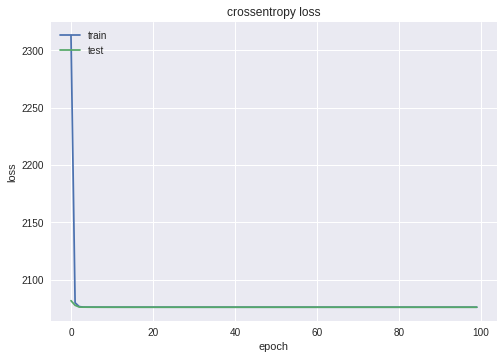

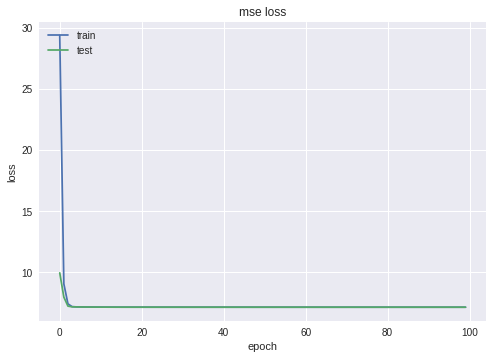

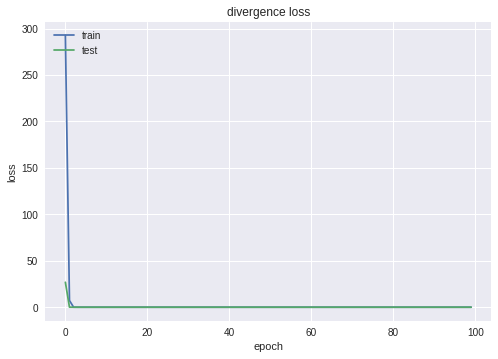

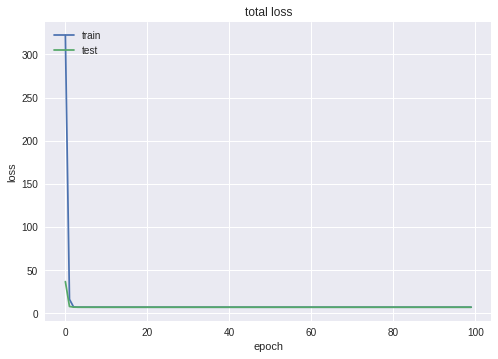

In [0]:
#with open ('drive/Seminar/data/history.pickle', 'rb') as f:
    #history = pickle.load(f)

# summarize history for crossentropy loss
plt.plot(history.history['xent_loss'])
plt.plot(history.history['val_xent_loss'])
plt.title('crossentropy loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for mse loss
plt.plot(history.history['mse_loss'])
plt.plot(history.history['val_mse_loss'])
plt.title('mse loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for divergence loss
plt.plot(history.history['kl_loss'])
plt.plot(history.history['val_kl_loss'])
plt.title('divergence loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for total loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Generating Text From Latent Space

### Save samples to file

In [0]:
# select sample and save to file

with open ('drive/Seminar/data/reviews_processed.pickle', 'rb') as f:
    data = pickle.load(f)
print("Total reviews: ", len(data))

data_concat = []
sample_size = 1000
for x in data[:sample_size]:
  data_concat.append(list(itertools.chain.from_iterable(x)))
  
data_array = np.array(data_concat)
print("Sample size: ", sample_size)

with open ('drive/Seminar/data/reviews_sample.pickle', 'wb') as f:
    pickle.dump(data_array,f)

    
# scale samples for encoding

with open ('drive/Seminar/data/scale_values.pickle', 'rb') as f:
    scale_values = pickle.load(f)
    
data_min = scale_values['min']
data_max = scale_values['max']

data_array_scaled = data_array
data_array_scaled = np.interp(data_array_scaled, (data_min, data_max), (0, 1))

Total reviews:  91798
Sample size:  1000


In [0]:
# encode and decode samples

sent_encoded = encoder.predict(data_array_scaled, batch_size=500)

sent_decoded = generator.predict(sent_encoded)
sent_decoded = np.interp(sent_decoded, (0, 1), (data_min, data_max))

with open ('drive/Seminar/data/reviews_sample_decoded.pickle', 'wb') as f:
    pickle.dump(sent_decoded,f)

In [0]:
# generate new sentences

n_sentences = 1000
random = [np.random.normal(0., epsilon_std*0.4, latent_dim) for x in range(n_sentences)]
random = np.array(random).reshape(-1,latent_dim)
sent_generated = generator.predict(random)
sent_generated = np.interp(sent_generated, (0, 1), (data_min, data_max))

with open ('drive/Seminar/data/reviews_sample_generated.pickle', 'wb') as f:
    pickle.dump(sent_generated,f)

### Print samples as strings

In [0]:
w2v = KeyedVectors.load_word2vec_format('drive/Seminar/data/GoogleNews-vectors-negative300.bin', binary=True)  

In [0]:
# load original, decoded and generated samples

with open ('drive/Seminar/data/reviews_sample.pickle', 'rb') as f:
    sample = pickle.load(f)
    
with open ('drive/Seminar/data/reviews_sample_decoded.pickle', 'rb') as f:
    sample_decoded = pickle.load(f)
    
with open ('drive/Seminar/data/reviews_sample_generated.pickle', 'rb') as f:
    #sample_generated = pickle.load(f)

In [0]:
# input: original dimension sentence vector
# output: text

def print_sentence_with_w2v(sent_vect):
    word_sent = ''
    tocut = sent_vect
    for i in range (int(len(sent_vect)/300)):
        word_sent += w2v.most_similar(positive=[tocut[:300]], topn=1)[0][0]
        word_sent += ' '
        tocut = tocut[300:]
    print(word_sent)

In [0]:
# compare original and reconstructed sentences

for i in range(10):
  print_sentence_with_w2v(sample[i])
  print_sentence_with_w2v(sample_decoded[i])
  print()

In [0]:
# print generated sentences

for i in range(10):
  print_sentence_with_w2v(sample_generated[i])

## Evaluating Anomaly Score

In [0]:
#load values for data scaling

with open ('drive/Seminar/data/scale_values.pickle', 'rb') as f:
    scale_values = pickle.load(f)
    
data_min = scale_values['min']
data_max = scale_values['max']

In [0]:
#load positive data (reviews)

with open ('drive/Seminar/data/reviews_processed_detection.pickle', 'rb') as f:
    pos_data = pickle.load(f)
print("Total reviews (positive data): ", len(pos_data))

pos_data_concat = []
for x in pos_data:
  pos_data_concat.append(list(itertools.chain.from_iterable(x)))
  
pos_data_array = np.array(pos_data_concat)
original_data = pos_data_array
pos_data_array = np.interp(pos_data_array, (data_min, data_max), (0, 1))
pos_data_array.shape

Total reviews (positive data):  10000


(10000, 3000)

In [0]:
pos_scores = {'loss': [], 'xent_loss': [], 'mse_loss': [], 'kl_loss': []}

for sample in pos_data_array:
  sample = sample.reshape(1,-1)
  scores = vae.evaluate(sample, sample, batch_size=1, verbose=0)
  pos_scores['loss'].append(scores[0])
  pos_scores['xent_loss'].append(scores[1])
  pos_scores['mse_loss'].append(scores[2])
  pos_scores['kl_loss'].append(scores[3])

In [0]:
#load negative data (news headlines)

with open ('drive/Seminar/data/news_processed.pickle', 'rb') as f:
    neg_data = pickle.load(f)
print("Total news headlines (negative data): ", len(neg_data))

neg_data_concat = []
for x in neg_data:
  neg_data_concat.append(list(itertools.chain.from_iterable(x)))
  
neg_data_array = np.array(neg_data_concat)
neg_data_array = np.interp(neg_data_array, (data_min, data_max), (0, 1))
neg_data_array.shape

Total news headlines (negative data):  10000


(10000, 3000)

In [0]:
neg_scores = {'loss': [], 'xent_loss': [], 'mse_loss': [], 'kl_loss': []}

for sample in neg_data_array:
  sample = sample.reshape(1,-1)
  scores = vae.evaluate(sample, sample, batch_size=1, verbose=0)
  neg_scores['loss'].append(scores[0])
  neg_scores['xent_loss'].append(scores[1])
  neg_scores['mse_loss'].append(scores[2])
  neg_scores['kl_loss'].append(scores[3])

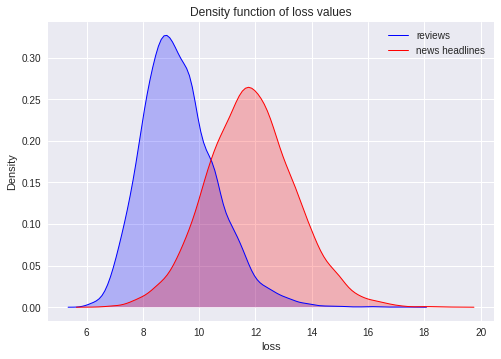

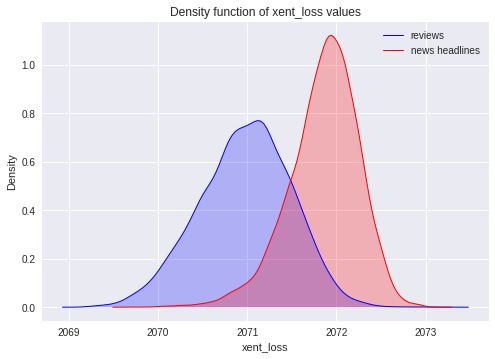

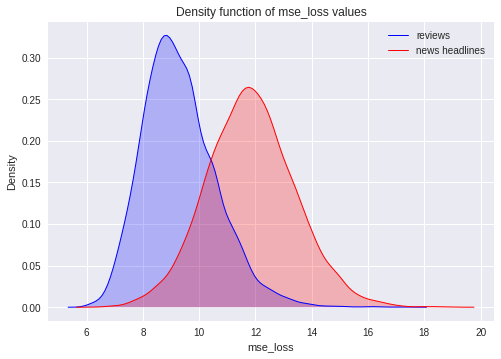

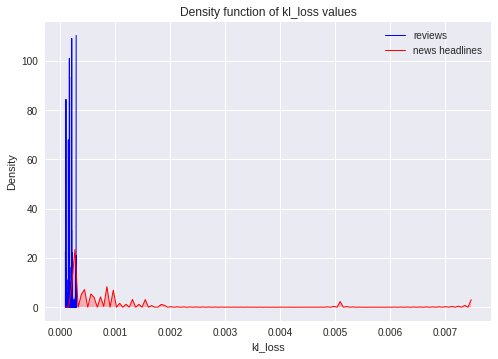

In [0]:
for score in ['loss', 'xent_loss', 'mse_loss', 'kl_loss']:
  plt.figure()
  ax1 = sns.distplot(pos_scores[score] , hist = False, kde = True,
                   kde_kws = {'linewidth': 1, 'shade':True}, label='reviews',color="blue")
  ax2 = sns.distplot(neg_scores[score] , hist = False, kde = True,
                   kde_kws = {'linewidth': 1, 'shade':True}, label='news headlines', color= "red")



  plt.title('Density function of '+score+' values')
  plt.xlabel(score)
  plt.ylabel('Density')
  plt.legend()

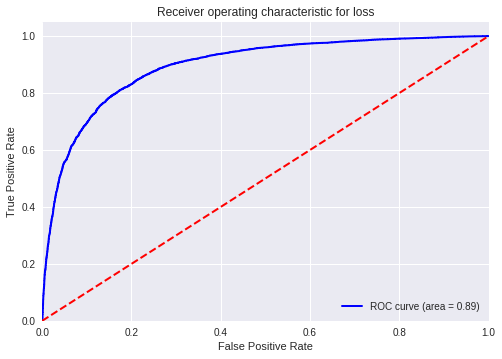

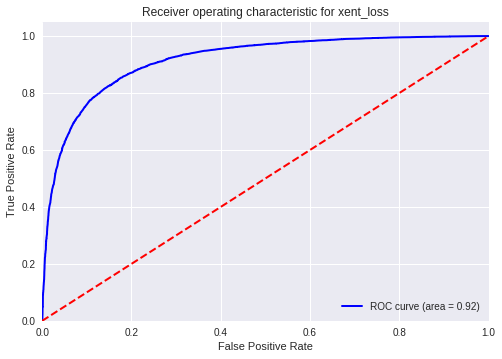

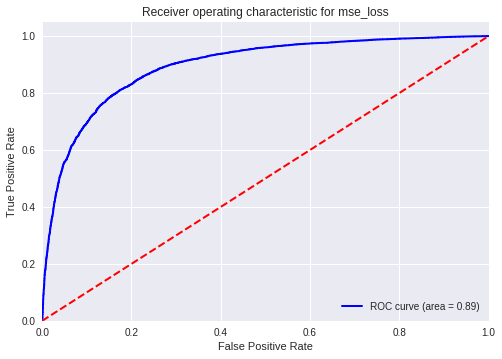

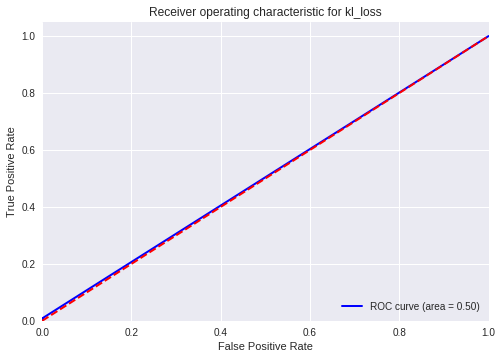

In [0]:
for score in ['loss', 'xent_loss', 'mse_loss', 'kl_loss']:
  
  y_true_pos = np.ones(len(pos_scores[score]))
  y_true_neg = np.zeros(len(neg_scores[score]))
                        
  y_true = np.concatenate((y_true_pos, y_true_neg))
  y_pred = np.concatenate((pos_scores[score], neg_scores[score]))

  fpr, tpr, thresholds = skl.roc_curve(y_true, y_pred, pos_label=0)
  roc_auc = skl.auc(fpr, tpr)  
  
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='blue',
           lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic for '+score)
  plt.legend(loc="lower right")
  plt.show()

## Regular Reviews vs Food Reviews

In [0]:
#load semi negative data (food reviews)

with open ('drive/Seminar/data/food_reviews_processed.pickle', 'rb') as f:
    semi_data = pickle.load(f)
print("Total food reviews (semi negative data): ", len(semi_data))

semi_data_concat = []
for x in semi_data:
  semi_data_concat.append(list(itertools.chain.from_iterable(x)))
  
semi_data_array = np.array(semi_data_concat)
semi_data_array = np.interp(semi_data_array, (data_min, data_max), (0, 1))
semi_data_array.shape

Total food reviews (semi negative data):  10000


(10000, 3000)

In [0]:
semi_scores = {'loss': [], 'xent_loss': [], 'mse_loss': [], 'kl_loss': []}

for sample in semi_data_array:
  sample = sample.reshape(1,-1)
  scores = vae.evaluate(sample, sample, batch_size=1, verbose=0)
  semi_scores['loss'].append(scores[0])
  semi_scores['xent_loss'].append(scores[1])
  semi_scores['mse_loss'].append(scores[2])
  semi_scores['kl_loss'].append(scores[3])

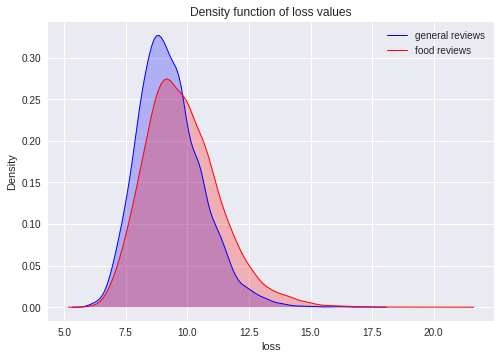

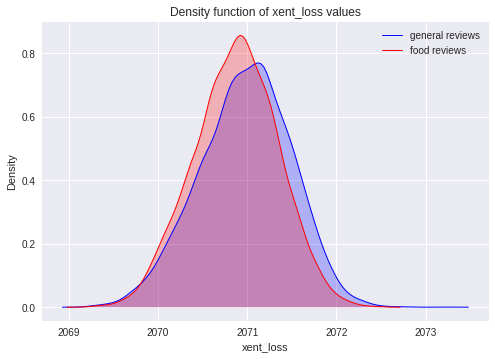

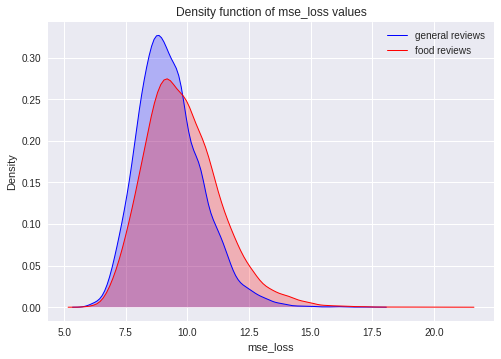

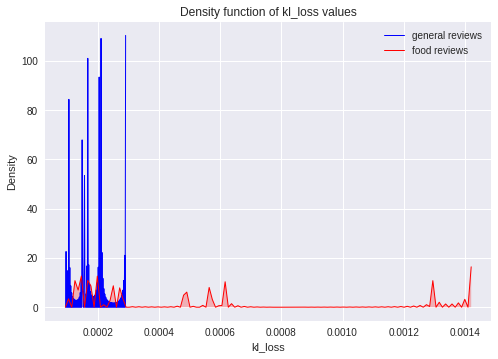

In [0]:
for score in ['loss', 'xent_loss', 'mse_loss', 'kl_loss']:
  plt.figure()
  ax1 = sns.distplot(pos_scores[score] , hist = False, kde = True,
                   kde_kws = {'linewidth': 1, 'shade':True}, label='general reviews',color="blue")
  ax2 = sns.distplot(semi_scores[score] , hist = False, kde = True,
                   kde_kws = {'linewidth': 1, 'shade':True}, label='food reviews', color= "red")



  plt.title('Density function of '+score+' values')
  plt.xlabel(score)
  plt.ylabel('Density')
  plt.legend()

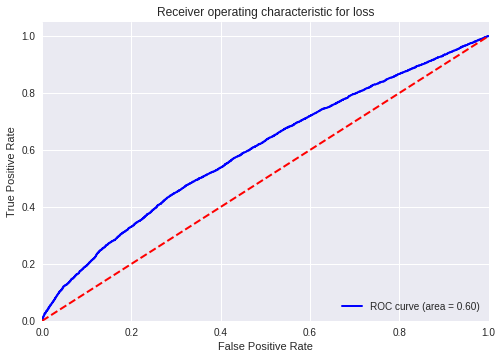

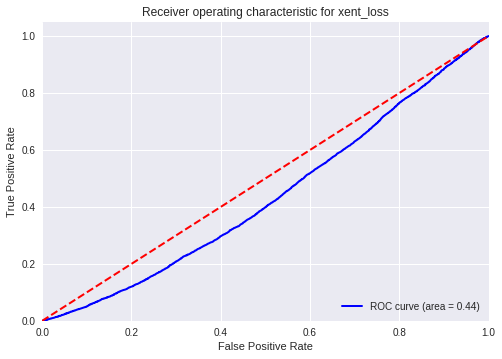

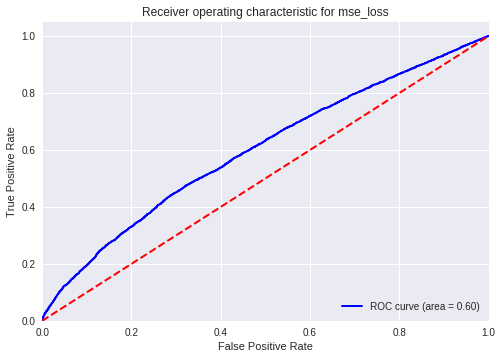

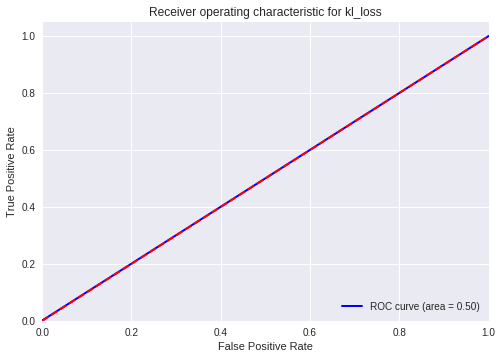

In [0]:
for score in ['loss', 'xent_loss', 'mse_loss', 'kl_loss']:
  
  y_true_pos = np.ones(len(pos_scores[score]))
  y_true_semi = np.zeros(len(semi_scores[score]))
                        
  y_true = np.concatenate((y_true_pos, y_true_semi))
  y_pred = np.concatenate((pos_scores[score], semi_scores[score]))

  fpr, tpr, thresholds = skl.roc_curve(y_true, y_pred, pos_label=0)
  roc_auc = skl.auc(fpr, tpr)  
  
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='blue',
           lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic for '+score)
  plt.legend(loc="lower right")
  plt.show()